# Tokenize the table content and check the distribution of tokens

Author: Riccardo Cappuzzo

In this notebook and some associated scripts I'll tokenize the content of the 
tables in the corpus, then tally the tokens to find what the most frequent ones
are. The idea is to figure out what are the most important tokens among all those
identified on this real data corpus.

I will test different strategies and libraries, including the functions in the 
`tokenizers` library, and the `CountVectorizer` transformer from `scikit-learn`. 


The first cell includes all the imports that are needed for this notebook. 

I'll start by importing some of the `normalizers` from the `tokenizer` library. 

More on `normalizers` in the [normalizers API page](https://huggingface.co/docs/tokenizers/v0.13.2/en/api/normalizers).
These normalizers rely on [unicode normalization](https://unicode.org/reports/tr15/).


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

from tokenizers.normalizers import NFD, StripAccents, Lowercase
from tokenizers import normalizers, pre_tokenizers, Tokenizer
from tokenizers.pre_tokenizers import Whitespace, Digits
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

# For reformatting tables
import pyarrow.parquet as pq
import pyarrow.csv as pv
from csv import QUOTE_NONE

# For path and file operations
import os.path as osp
import os
import glob
from random import sample
from joblib import Parallel, delayed

# For progress bar
from tqdm import tqdm

# For plotting and operations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Converting csv files into text files

I'll start by "globbing" all the table paths. I'll have to first convert all the tables to 
text, then feed all the files to the tokenizer. After building the tokenizer, I'll go back and encode all tables again to 
find the most frequent tokens. 

In [39]:
# Creating a new dir for the dumped data
dest_dir = "data/zenodo/txt_tables"
os.makedirs(dest_dir, exist_ok=True)

In [20]:
# Creating a list with the paths for all tables in the collection
ls = glob.glob("data/zenodo/tables/*/*")
print(f"Found {len(ls)} files.")

For debugging, I'll select a small sample of tables first.

In [26]:
ls_sample = sample(ls, k=100)

I'll use joblib to parallelize the next steps.

In [106]:
def dump_table_to_csv(idx, table_path, dest_dir):
    try:
        tgt_dir, path = osp.split(osp.relpath(table_path, "data/zenodo/tables/"))
        path = osp.join(dest_dir, tgt_dir, osp.basename(path) + ".txt")
        print(path)
        if osp.exists(path):
            return (idx, 0)
        # print(path)
        # tab = pq.read_table(table_path)
        # tab.to_pandas().to_csv(path,  index=False, sep=" ", escapechar=" ", quoting=QUOTE_NONE)
        return (idx, 0)
    except Exception:
        return (idx, 1)


I don't really care about the result, since the conversion is the actual operation. Still, it's useful for tracking down those files that were not converted successfully for some 
reason. 

In [108]:
r = Parallel(n_jobs=1, verbose=0)(
    delayed(dump_table_to_csv)(
        idx, table_path, dest_dir) for idx, table_path in 
    tqdm(enumerate(ls[:10]), position=0, leave=False, total=len(ls)))

data/zenodo/txt_tables/abstraction_tables_licensed/Designite_Microsoft.Phone.Tools.Deploy.Patched_DesignSmells.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/Designite_VisualEffectPlayground_DesignSmells.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/Designite_Reign.Input.API_DesignSmells.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/08-09_18.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/13-14_43.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/Designite_Chinook_DesignSmells.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/03-04_81.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/Designite_squidtray_DesignSmells.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/Designite_ThreadedCoreData_DesignSmells.parquet.txt
data/zenodo/txt_tables/abstraction_tables_licensed/Designite_Helpmebot.Tests_DesignSmells.parquet.txt


In [75]:
print(f"There are {len(r)} results, and {len(os.listdir(dest_dir))} files in {dest_dir}.")

There are 1018624 results, and 562190 files in data/zenodo/txt_tables.


It looks like about half of the tables have been overwritten because of repeated filenames. 

Whoops. 

Time to run this again, this time placing each file in its folder. 

To reduce the cost of each operation, all folders are created before running the code, and 
then populated while iterating. 

In [90]:
for tab in glob.glob("data/zenodo/tables/*"):
    os.makedirs(osp.join(dest_dir, osp.basename(tab)), exist_ok=True)

In [104]:
table_path = ls_sample[0]
tgt_dir, path = osp.split(osp.relpath(table_path, "data/zenodo/tables/"))
path = osp.join(dest_dir, tgt_dir, osp.basename(path) + ".txt")
print(path)

data/zenodo/txt_tables/abstraction_tables_licensed/Designite_SqlLinq.UnitTests_DesignSmells.parquet.txt


I exported the updated code to `src/convert_tables_to_text.py`, then ran it on drago3
(around 45min runtime for the entire corpus).

### Tokenizing with scikit-learn CountVectorizer

In [2]:
pwd

'/home/soda/rcappuzz/work/study-gittables/notebooks'

In [9]:
corpus_files = glob.glob("../data/zenodo/txt_tables/*/*")

In [27]:
vectorizer = CountVectorizer(input="filename", analyzer="word", ngram_range=(2,2))
target_table_path = "data/zenodo/tables/allegro_con_spirito_tables_licensed/Aziende.parquet"
tab = pq.read_table("data/zenodo/tables/allegro_con_spirito_tables_licensed/Aziende.parquet")
tab.to_pandas().to_csv("tb.txt",  index=False, sep=" ", escapechar=" ", quoting=QUOTE_NONE)

<1x21796 sparse matrix of type '<class 'numpy.int64'>'
	with 21796 stored elements in Compressed Sparse Row format>

In [28]:
X = vectorizer.fit_transform(["tb.txt"])
words = vectorizer.get_feature_names_out()

In [29]:
counts = X.sum(axis=0)
counts_array = np.squeeze(np.asarray(counts))

word_counts = np.concatenate([words, counts_array], axis=0).reshape(2, -1)
word_counts

array([['10022302399 filadelfio', '10071426446 manlio',
        '10115459029 fiovo', ..., 'zuliani silvia', 'zullino famila',
        'zza san'],
       [1, 1, 1, ..., 1, 1, 1]], dtype=object)

The `CountVectorizer` produced a collection of 2-value combinations, and tallied how often they occur. 

In [46]:
df = pd.DataFrame(word_counts.T, columns=["word", "count"])

Plotting the frequency of each n-gram. 

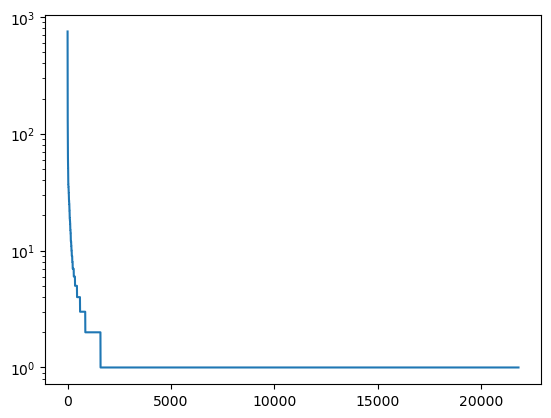

In [75]:
fig, ax = plt.subplots()
ax.plot(df.index, df["count"].sort_values(ascending=False))
ax.set_yscale("log")

Overall, this wasn't particularly useful

## Tokenizing with the `tokenizers` library

In [3]:
normalizer = normalizers.Sequence([NFD(), Lowercase(), StripAccents()])
# Testing normalizer
normalizer.normalize_str("Héllò hôw are ü?")
pre_tokenizer = pre_tokenizers.Sequence([Whitespace(), Digits()])
# Testing pre-tokenizer
pre_tokenizer.pre_tokenize_str("Call 911!")
# Creating the tokenizer with the assigned normalizer and pre-tokenizer
tokenizer = Tokenizer(BPE())
tokenizer.normalizer = normalizer
tokenizer.pre_tokenizer = pre_tokenizer

In [20]:
cd /home/soda/rcappuzz/work/study-gittables

/home/soda/rcappuzz/work/study-gittables


### Preparing a random table for tokenization

In [21]:
tab = pq.read_table("data/zenodo/tables/allegro_con_spirito_tables_licensed/Aziende.parquet")

Saving the table to csv, removing all quotation and separators. `QUOTE_NONE` is 
used to remove all quote markers, `escapechar` is needed to avoid `csv` to throw
an error. By using `sep=" "` and `escapechar=" "`, there is no quoting and 
all fields are separated by `"  "` (two spaces).  

In [22]:
tab.to_pandas().to_csv("tb.txt",  index=False, sep=" ", escapechar=" ", quoting=QUOTE_NONE)

### Tokenizing the content of the table

In [24]:
trainer = BpeTrainer() # No special tokens for now
tokenizer.train(["tb.txt"], trainer)
# Testing the encoder on random letters
tokenizer.encode("It's Captain Jack Sparrow").tokens

['i', 't', 's', 'cap', 'ta', 'in', 'jack', 'spar', 'ro', 'w']

### Tokenizing *ALL THE TABLES*

I actually used `tokenize_with_lib.py` to do so, rather than running the code in the notebook. The result is the file
`data/tokenizer.json`, which I will be loading here. 

In [13]:
tokenizer = Tokenizer.from_file("../data/tokenizer.json")

The next step is tallying all tokens. I will be doing this in the `encode_with_lib.py`.

### Reading the counter

In [76]:
import json

In [77]:
global_counter = json.load(open("global_counter.json", "r"))

In [78]:
count_df = pd.DataFrame().from_dict(global_counter, orient="index",columns=["count"])

In [105]:
reset = count_df.reset_index().sort_values(["count"], ascending=False)
mean_count = reset["count"].mean()
median_count = reset["count"].median()

In [190]:
print(mean_count)
print(median_count)

174199.0341
13674.0


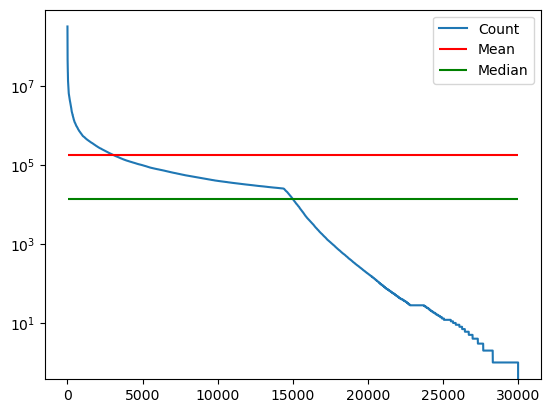

In [117]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(reset)), reset["count"], label="Count")
ax.set_yscale("log")
ax.hlines(mean_count, 10, 30000, color="red", label="Mean")
ax.hlines(median_count, 10, 30000, color="green", label="Median")
plt.legend()

In [118]:
more_frequent = reset.loc[reset["count"] > median_count]

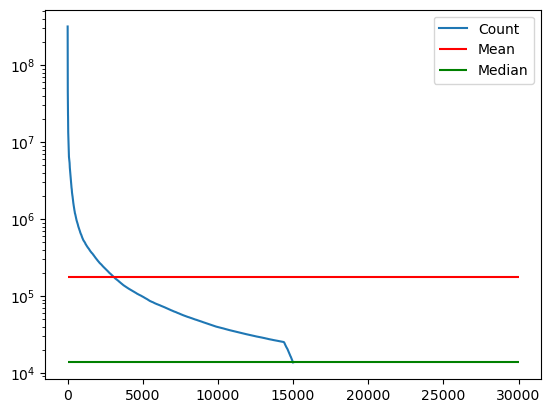

In [119]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(more_frequent)), more_frequent["count"], label="Count")
ax.set_yscale("log")
ax.hlines(mean_count, 10, 30000, color="red", label="Mean")
ax.hlines(median_count, 10, 30000, color="green", label="Median")
plt.legend()

In [171]:
top_200 = reset[:200]["index"]

In [151]:
import re


In [167]:
for val in top_200[:10]:
    if match_words.match(val).group():
        print(val, "word")
    elif match_numbers.match(val).group():
        print(val, "number")
    else:
        print(val, "punct")

. punct
0 number
- punct
/ punct
, punct
the word
a word
1 number
to word
' punct


In [168]:
classes = np.zeros_like(top_200)

In [169]:
def map_to_class(val):
    match_words = re.compile(r"[a-z]*")
    match_numbers = re.compile(r"[0-9]*")
    if match_words.match(val).group():
        return 0
    elif match_numbers.match(val).group():
        return 1
    else:
        return 2

/tmp/ipykernel_48632/2011836442.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sns.heatmap(reset["index"][:15000].apply(map_to_class).values.reshape(-1, 50))


<AxesSubplot: >

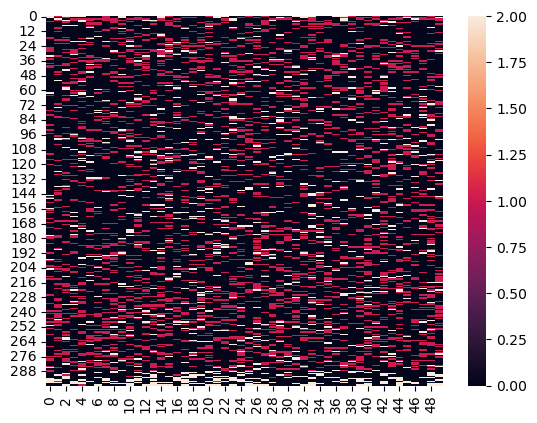

In [189]:
sns.heatmap(reset["index"][:15000].apply(map_to_class).values.reshape(-1, 50))

In [188]:
reset[-50:]

,index,count
6111,䶰,1
14533,⬍,1
28091,󾌺,1
21327,⭒,1
2331,匸,1
18639,爫,1
18624,🠫,1
14653,𐑲,1
6306,鲭,1
11017,🠊,1
